<a href="https://colab.research.google.com/github/aalling93/ENGR562_CNN/blob/master/A_study_of_CNN_github_with_GOOD_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN MODEL

Building a CNN model is easy! In this notebook, the theory from the article 'A study of Convolutional Neural Network'[Sorensen(2019)] will be implemented in a simple CNN.

This model is a simpler version of the one covered in [Sorensen(2019)]. Here, a model is build for the sole purpose of showing a predictions

Many frameworks and libraries usefull for machine learning exists.  Here, the keras library is used in order to utilize the Tensorflow framework.

This notebook covers the following:

- Initialization: installing and importing packages.
- Importing a dataset: A dataset is needed to build and train a model. 
- Preparing the model: Defining the hyperparamters used.
- Building a model: Using layers, fundtions ect as seen in [Sorensen(2019)].
- Training the model: Using the imported data, the build model is trained using a loss function and optimizer.
- Visualization of intermediate CNN results and statistics 
- Saving the model
- Prediction.

For further tutorials, see e.g.  https://medium.com/nybles/create-your-first-image-recognition-classifier-using-cnn-keras-and-tensorflow-backend-6eaab98d14dd or https://towardsdatascience.com/cnn-architectures-a-deep-dive-a99441d18049

## Initialization
Firstly, install needed packages and check for version.  







In [1]:
#! pip install torch
#! pip install torchvision
#! pip install pandas==0.23.4
#! pip install geopandas
#! pip install keras
#! pip install tensorflow
#! pip install tf-nightly
#! pip install ggplot
#! pip install -U PyYAML
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

from __future__ import absolute_import, division, print_function, unicode_literals
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from PIL import Image as pil_image
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from keras.constraints import max_norm
#To visualize it..
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
# FUNCTIONS
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,want_title=None):
    """
    This function prints and plots the confusion matrix. Noting more... It uses the sklearn lib.
    Normalization can be applied by setting `normalize=True`.
    """
    #making title.. (for my article, i dont want then, thus the want_title)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    if want_title!= None:
      ax.set(xticks=np.arange(cm.shape[1]),
             yticks=np.arange(cm.shape[0]),
             # ... and label them with the respective list entries
             xticklabels=classes, yticklabels=classes,
             title=title,
             ylabel='True label',
             xlabel='Predicted label')
    else:
      ax.set(xticks=np.arange(cm.shape[1]),
             yticks=np.arange(cm.shape[0]),
             # ... and label them with the respective list entries
             xticklabels=classes, yticklabels=classes,
             ylabel='True label',
             xlabel='Predicted label')        

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # I dont want the actualy probabilities in the plot, since its meassy when exporting to latex. 
    # but, for examinations it's fine. 
    """
    Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    """
    return ax



print(tf.__version__)

TensorFlow 2.x selected.


Using TensorFlow backend.


2.0.0


## Importing a dataset

Here, im important a dataset from keras pre-defined data sets, see https://keras.io/datasets/

The CIFAR10 dataset:
Dataset of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images. It is thus good for illustrating pupose of a CNN. https://www.cs.toronto.edu/~kriz/cifar.html

The images are uint8 array of RGB image data with shape (num_samples, 3, 32, 32) or (num_samples, 32, 32, 3) based on the image_data_format backend setting of either
Since the dataset is predefined in Keras, it can do the labelling. Otherwise classes must be defined>

In [2]:
#loading the set directly from keras bucket.
cifar100 = tf.keras.datasets.cifar100
#defining training(test) data and its labels. The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#see a bit of stats..
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# The data is already labbeled.. Othervise, define into classes

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## Preparing the model

In [0]:
# Convert class vectors to binary class matrices.
num_classes = 10 #from 100 to 10 classes....# in the CIFAR10 theres 10 classes extracted from the CIFAR100 dataset..
y_test_scivit = np.squeeze(np.copy(y_test)) #used for confusin matrix in scilearn lib. AFTER predictions are made...
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

Here, the defined test data can be used to evaluate the model using the error function described in the theory. It could be applied as K-fold, leave-on-out or even a cross validation (take hella long time tho).

## Exploring the classes

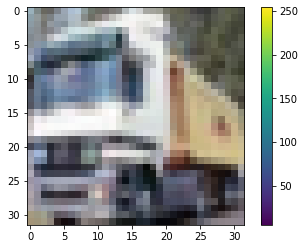

In [4]:
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.grid(False)
plt.show()
#lets see what we have.

## Building the CNN
layers, as described in the theory can now be added to the model
see https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

### Defining Hyper parameters

Hyper parameters to control the size of the output of CNN layer. Depth, stride and zero padding..


In [0]:
model_name = 'good_prediction.h5'
#filter size
filter_size = 3
#If padding isnt the deafult, this value should be used (now keras defult is used..)
padding  = (filter_size-1)/2
filter_size = (filter_size,filter_size)
# Stride controls the "overlap" between neighoboring convolutions. For sattellite image, a strid of e.g. 10 is smart . This reduces the dimension.. If stride=1, we move filter one pixel at a time. 
# atm, keras deafult is used = the same size as pooling.. 
stride = 3 
#depth is number of neurons(filters) in the given layer connected to the input (either original img or feature img).
filters_first_layer = 66 #currently this value is also used for other layers..
# Epoch is the number each batch is trained
epoch=100
#Using batch learning as in the theory
batch_size = 1000

### Making model

In [0]:
#------------------------ BUILING THE MODEL ------------------------------------
# Initializing the model using Sequntial(), The Sequential model is a linear stack of layers. https://keras.io/getting-started/sequential-model-guide/
model = Sequential()
#adding a convolutional layer, https://keras.io/layers/convolutional/
model.add(Conv2D(filters_first_layer, filter_size, padding='same',input_shape=x_train.shape[1:]))
#adding activation function
model.add(BatchNormalization())
model.add(Activation('relu'))
#adding Maxpooling as described in the theory and https://keras.io/layers/pooling/. Default stride is the same as pool..
model.add(MaxPooling2D(pool_size=(2, 2)))
#regularization, https://keras.io/layers/core/
model.add(Dropout(0.1))
#this "block" of layers (convolutional layer, activation, pooling and regularization) can now be applied a number of times.... i.e copy pastye..
# ---- 2nd block
model.add(Conv2D(filters_first_layer, filter_size))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# --- 3rd block -------
model.add(Conv2D(filters_first_layer*2, filter_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# --- 4rd block -------
model.add(Conv2D(filters_first_layer*2, filter_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# --- 5th block -------
model.add(Conv2D(filters_first_layer*2, filter_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
#Flattens the input. Does not affect the batch size needed for FC... see https://medium.com/nybles/create-your-first-image-recognition-classifier-using-cnn-keras-and-tensorflow-backend-6eaab98d14dd
model.add(Flatten())
#model.add(Dense(512, kernel_constraint=max_norm(2.)))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
#Just your regular densely-connected NN layer, i.e. the FC...adding different weight regularizers. Lastly,activation function to classify...
model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),activity_regularizer=regularizers.l2(0.001),activation='softmax'))

## Training the model 

### Define back propagation optimizer and loss function.
In the theory, the equation for the Gradient Descent is explained. This is optimizer is used with the loss of cross entropy.

Recall. Gradient descent applied to a batch is called mini-batch learning.


Optimizer: https://keras.io/optimizers/.

Loss function: https://keras.io/losses/.

In [7]:
# an optimizer is required to train a keras model, https://keras.io/optimizers/. As described in the theory, as GRADIENT DESCENT is used here..
#  The loss function is here defined, https://keras.io/losses/. In the theory, the kullback_leibler_divergence and cross entropy..  Since classes are integer, sparse_categorical_crossentropy is used
optimizer = keras.optimizers.SGD(lr=0.005)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
print("Showing sizes of datasets..")
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

Showing sizes of datasets..
(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In illustation of the data, we saw the scale on the colour plot. This is scalled to [0,1] before its used to fit the model.

In [0]:
#Scaling the data from [0:255] to [0:1]..
x_test = x_test.astype('float32')
x_train = x_train.astype('float32')
x_train /= 255
x_test /= 255

### Fitting the model:
Using the model of the CNN, the model is not TRAINED using the labels.
- the batch size is used (how many feature maps in one batch)
- the epochs are used (how many times a batch is trained)
Moreover, the training data is used (data and labels) to train, and is validated on the test data (data and labels)


In [9]:
#https://keras.io/models/sequential/
# History is used to track the changed for plotting..
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epoch, validation_data=(x_test, y_test),shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 6s 115us/sample - loss: 2.3794 - accuracy: 0.1393 - val_loss: 2.3226 - val_accuracy: 0.0958
Epoch 2/100
50000/50000 [==============================] - 3s 51us/sample - loss: 2.2013 - accuracy: 0.1948 - val_loss: 2.3245 - val_accuracy: 0.0997
Epoch 3/100
50000/50000 [==============================] - 3s 54us/sample - loss: 2.0999 - accuracy: 0.2317 - val_loss: 2.3361 - val_accuracy: 0.1014
Epoch 4/100
50000/50000 [==============================] - 3s 53us/sample - loss: 2.0243 - accuracy: 0.2608 - val_loss: 2.3640 - val_accuracy: 0.1069
Epoch 5/100
50000/50000 [==============================] - 3s 53us/sample - loss: 1.9602 - accuracy: 0.2844 - val_loss: 2.4044 - val_accuracy: 0.1088
Epoch 6/100
50000/50000 [==============================] - 3s 53us/sample - loss: 1.9105 - accuracy: 0.3019 - val_loss: 2.4374 - val_accuracy: 0.1108
Epoch 7/100
50000/50000 [========================

##  Visualization of results
Here, I will visualize the model and the results.. Firstly, the model itself will be shown in graph form. Thereafter, a summary of the statistics and more will be shown. 
Latsly, plots showing accuracy, preccision and more will be made.


### Model illustartion

Not only does the graph model illustrates the layers, where we easily can see e.g. the downsampling in the maxpooling layer.  We also see the order of the layers. Here we can check that the layers indeed are in correct order (conv, activation, normalization, pooling ect)..

Similarty, the number of parameters is seen and the shape of especially the output layers.




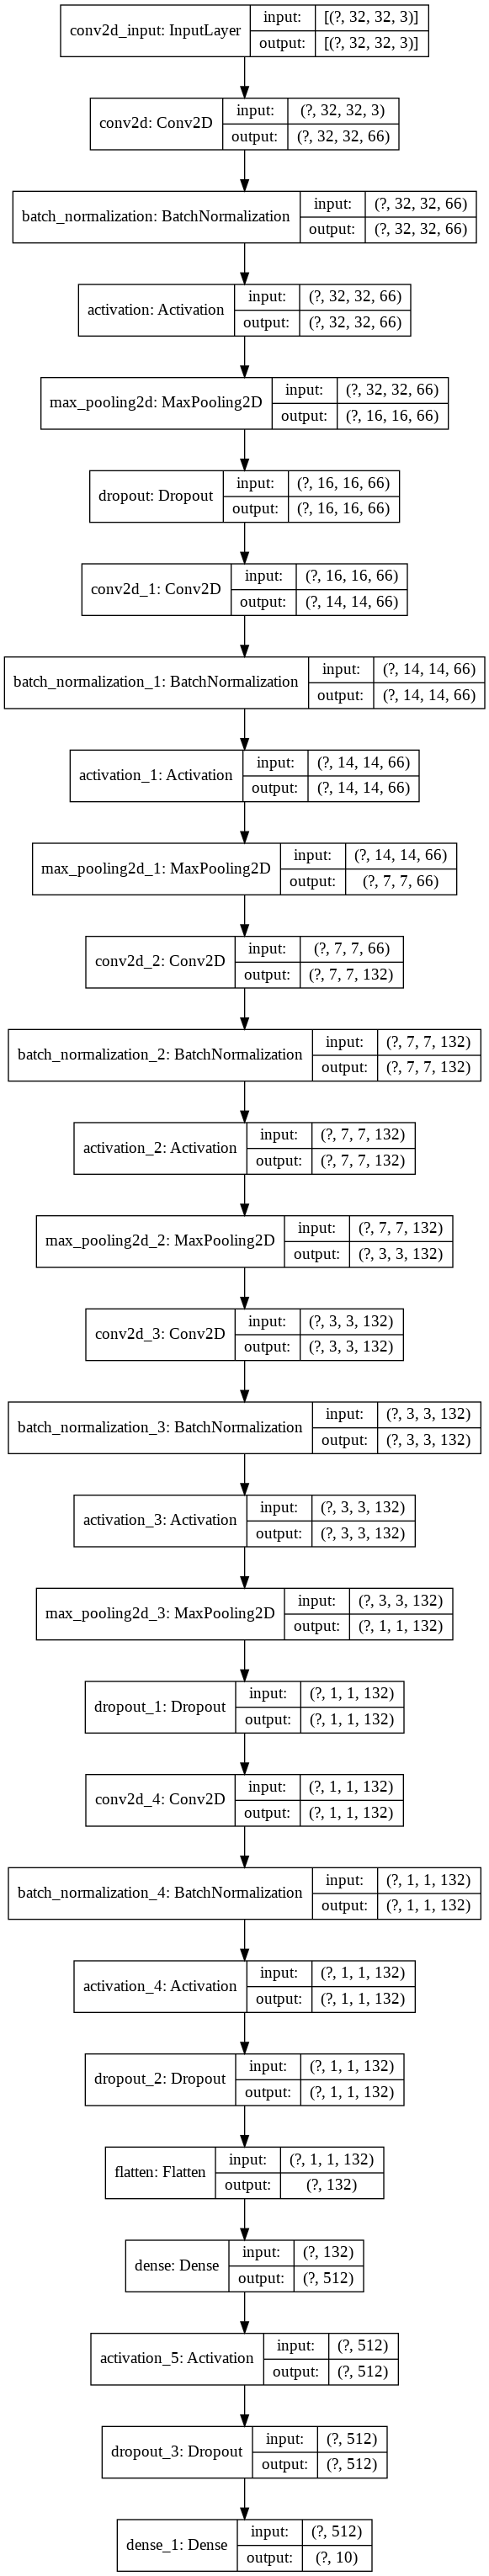

In [10]:
plot_model(model, to_file='model_plot_CNNmodel_name.png', show_shapes=True, show_layer_names=True)

### Statistics

In the statistics, we see the shape of the model, the number of weights in each layer as well as the total number of trained and non-trained parameters.



In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 66)        1848      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 66)        264       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 66)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 66)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 66)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 66)        39270     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 66)        2

### training and validation accuracy values


In [0]:
#scores = model.evaluate(x_test, y_test, verbose=1);
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])

In [13]:
# list all data in history
print(history.history.keys());

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


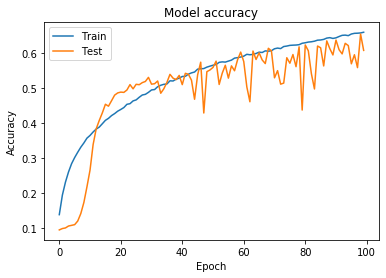

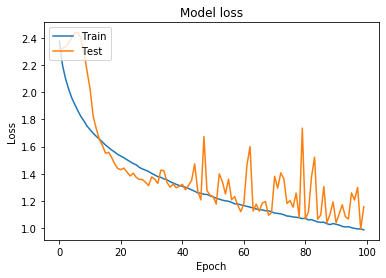

In [14]:
#can render the model myself..
SVG(model_to_dot(model).create(prog='dot', format='svg'))
#sometime it changes from acc to accuracy, use the list above to write correct names...
if epoch>1:
  # display if theres more than one epoch.
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

 here, it can be seen after which epoch (if more are used) the odel starts to overfit..

 Here, it can be seen that after 175 epochs,the model starts to overfit. (Training acc is larger than valdation acc, which should be possible without overfitting, and training loss is less than actual valdation loss)...
 

## Make predictions

#### Making a classification 'report' and a confusion matrix

In [15]:
predictions = model.predict(x_test, verbose=0)  #https://www.tensorflow.org/tutorials/keras/classification
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)



# Have true classes (y_test). in order to make confusion matrix im chaning to Pythn scikit lib. (could use others)
import sklearn.metrics as metrics
#therefore, getting stats in scicit (even if I have it fron keras..)
report = metrics.classification_report(y_test_scivit, predicted_classes)
print(report) 

              precision    recall  f1-score   support

           0       0.88      0.34      0.49      1000
           1       0.83      0.73      0.77      1000
           2       0.63      0.34      0.44      1000
           3       0.49      0.36      0.42      1000
           4       0.40      0.70      0.51      1000
           5       0.61      0.53      0.57      1000
           6       0.46      0.93      0.62      1000
           7       0.76      0.66      0.71      1000
           8       0.75      0.74      0.75      1000
           9       0.76      0.74      0.75      1000

    accuracy                           0.61     10000
   macro avg       0.66      0.61      0.60     10000
weighted avg       0.66      0.61      0.60     10000



Making confusion matrix and showing (normalized and not). If values are wanted, remove ''' in function...

Confusion matrix, without normalization
[[335  32 109  20 184   7  81  23 158  51]
 [  4 728   0   8  17   3  84  11  26 119]
 [ 15   1 335  52 260  79 223  24   6   5]
 [  1   2  30 363 133 155 277  26   6   7]
 [  2   1   9  22 703   9 190  52  10   2]
 [  0   0  19 188 119 530 104  34   2   4]
 [  1   1   3  18  35   5 934   3   0   0]
 [  2   1  14  17 202  69  32 657   2   4]
 [ 16  34   7  34  51   5  64   9 740  40]
 [  4  80   4  24  32   7  47  24  33 745]]
Normalized confusion matrix
[[0.335 0.032 0.109 0.02  0.184 0.007 0.081 0.023 0.158 0.051]
 [0.004 0.728 0.    0.008 0.017 0.003 0.084 0.011 0.026 0.119]
 [0.015 0.001 0.335 0.052 0.26  0.079 0.223 0.024 0.006 0.005]
 [0.001 0.002 0.03  0.363 0.133 0.155 0.277 0.026 0.006 0.007]
 [0.002 0.001 0.009 0.022 0.703 0.009 0.19  0.052 0.01  0.002]
 [0.    0.    0.019 0.188 0.119 0.53  0.104 0.034 0.002 0.004]
 [0.001 0.001 0.003 0.018 0.035 0.005 0.934 0.003 0.    0.   ]
 [0.002 0.001 0.014 0.017 0.202 0.069 0.032 0.657 0.002 0.00

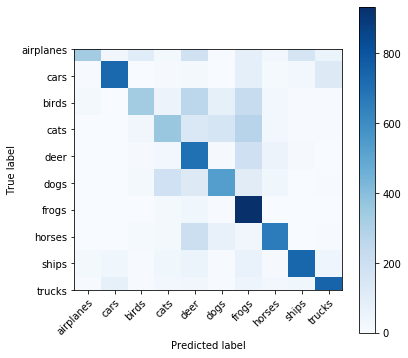

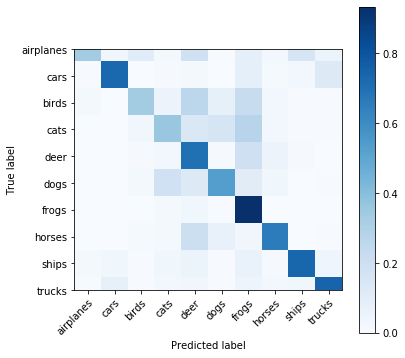

In [16]:
import numpy as np
#Defining classes for confusion matrix plot
classes = np.array(['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']);
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_scivit, predicted_classes, classes=classes,title='Confusion matrix, without normalization');
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_scivit, predicted_classes, classes=classes, normalize=True,title='Normalized confusion matrix');

## Save model and weights for further use.


In [17]:
from keras.models import load_model
from keras.models import model_from_json
from keras.models import model_from_yaml
import keras
 # creates a HDF5 file 

model.save(model_name) 
# Creates json file, to see architecture
# serialize model to JSON
model_json = model.to_json()
with open("last_try.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("weights_last_try.h5")
print("Saved model to disk")

print(model_name)

Saved model to disk
good_prediction.h5


In [18]:
!ls

 airplane.jpg
 deer.jpg
 frog.jpg
 good_prediction.h5
 last_try.h5
 last_try.json
 model_200Epochs.json
 model_plot_CNNmodel_name.png
 model_plot_CNN.png
 myCar2.png
 myCar.jpg
 sample_data
 ship.jpg
'Users'$'\002''8669364\Desktop\model\model_200Epochs.h5'
'Users'$'\002''8669364\Downloads\model_200Epochs.json'
'Users'$'\002''8669364\Downloads\weights_200Epochs.h5'
 weights_last_try.h5


[[9.7573382e-01 7.6716003e-04 1.2972299e-02 1.6077206e-04 4.8016463e-03
  3.2971690e-05 8.3732855e-05 2.2371132e-04 4.3617832e-03 8.6225709e-04]]
The picture belongs to class:  airplanes


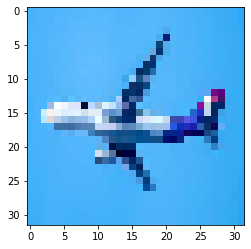

In [19]:

from keras.preprocessing import image
image2 = image.load_img('airplane.jpg',target_size=(32,32))
plt.imshow(image2)
image2 = image.img_to_array(image2)/255
image2 = np.expand_dims(image2,axis=0)
result = model.predict(image2)
predicted_class_indices=np.argmax(result)
print(result)
classes = np.array(['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']);
print('The picture belongs to class: ',classes[predicted_class_indices])

[[2.1886842e-03 2.9219743e-03 2.4617700e-02 3.3729014e-03 7.3460354e-03
  5.5764150e-04 9.5822805e-01 1.6512431e-04 2.8480819e-04 3.1711260e-04]]
The picture belongs to class:  frogs


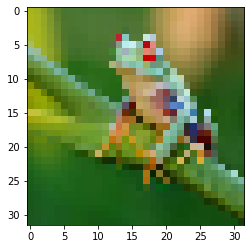

In [20]:
from keras.preprocessing import image
image2 = image.load_img('frog.jpg',target_size=(32,32))
plt.imshow(image2)
image2 = image.img_to_array(image2)/255
image2 = np.expand_dims(image2,axis=0)
result = model.predict(image2)
predicted_class_indices=np.argmax(result)
print(result)
classes = np.array(['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']);
print('The picture belongs to class: ',classes[predicted_class_indices])

The picture belongs to class:  cars


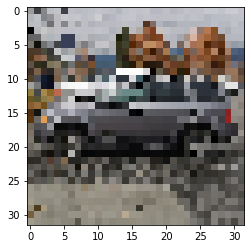

In [21]:
image2 = image.load_img('myCar.jpg',target_size=(32,32))
plt.imshow(image2)
image2 = image.img_to_array(image2)/255
image2 = np.expand_dims(image2,axis=0)
result = model.predict(image2)
predicted_class_indices=np.argmax(result,axis=1)
predicted_class_indices=np.argmax(result)
classes = np.array(['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']);
print('The picture belongs to class: ',classes[predicted_class_indices])

The picture belongs to class:  ships


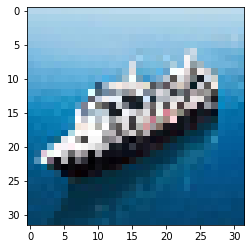

In [22]:
image2 = image.load_img('ship.jpg',target_size=(32,32))
plt.imshow(image2)
image2 = image.img_to_array(image2)/255
image2 = np.expand_dims(image2,axis=0)
result = model.predict(image2)
predicted_class_indices=np.argmax(result)
classes = np.array(['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']);
print('The picture belongs to class: ',classes[predicted_class_indices])

The picture belongs to class:  cars


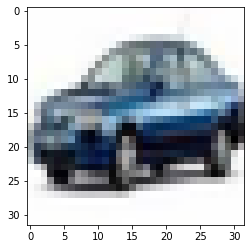

In [28]:
image2 = image.load_img('deer.jpg',target_size=(32,32))
image2 = x_train[105]
plt.imshow(image2)
image2 = image.img_to_array(image2)
image2 = np.expand_dims(image2,axis=0)
result = model.predict(image2)
predicted_class_indices=np.argmax(result)
classes = np.array(['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']);
print('The picture belongs to class: ',classes[predicted_class_indices])

The picture belongs to class:  trucks


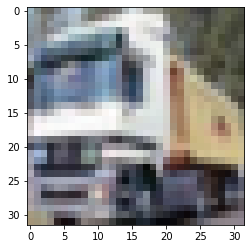

In [27]:
image2 = x_train[1]
plt.imshow(image2)
image2 = image.img_to_array(image2)
image2 = np.expand_dims(image2,axis=0)
result = model.predict(image2)
predicted_class_indices=np.argmax(result)
classes = np.array(['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']);
print('The picture belongs to class: ',classes[predicted_class_indices])


The picture belongs to class:  deer


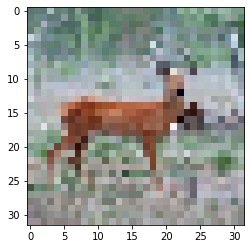

In [25]:
image2 = image.load_img('deer.jpg',target_size=(32,32))
plt.imshow(image2)
image2 = image.img_to_array(image2)/255
image2 = np.expand_dims(image2,axis=0)
result = model.predict(image2)
predicted_class_indices=np.argmax(result)
classes = np.array(['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']);
print('The picture belongs to class: ',classes[predicted_class_indices])